In [ ]:
# 📦 Importations
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# 📂 Préparer les données
data_dir = "../data/raw/chest_Xray/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

classes = dataset.classes
print("Classes :", classes)

Classes : ['NORMAL', 'PNEUMONIA']


In [3]:
# 🚀 Charger MobileNet pré-entraîné et l'adapter
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)  # 2 classes : NORMAL et PNEUMONIA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/zoidberg/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/home/zoidberg/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zoidberg/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|                                                                       | 0.00/13.6M [00:00<?, ?B/s]

 13%|████████                                                      | 1.75M/13.6M [00:00<00:00, 16.5MB/s]

 28%|█████████████████▏                                            | 3.75M/13.6M [00:00<00:00, 19.0MB/s]

 48%|█████████████████████████████▋                                | 6.50M/13.6M [00:00<00:00, 22.4MB/s]

 72%|████████████████████████████████████████████▌                 | 9.75M/13.6M [00:00<00:00, 26.7MB/s]

100%|██████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 27.9MB/s]

In [4]:
# ⚙️ Définir l'optimiseur et la fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Pour suivre Loss et Accuracy
train_losses = []
train_accuracies = []

In [5]:
# 🏋️ Boucle d'entraînement
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    model.train()
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

Epoch [1/5] - Loss: 0.3147 - Accuracy: 86.06%


Epoch [2/5] - Loss: 0.0942 - Accuracy: 96.79%


Epoch [3/5] - Loss: 0.0385 - Accuracy: 99.04%


Epoch [4/5] - Loss: 0.0320 - Accuracy: 98.88%


Epoch [5/5] - Loss: 0.0180 - Accuracy: 99.52%


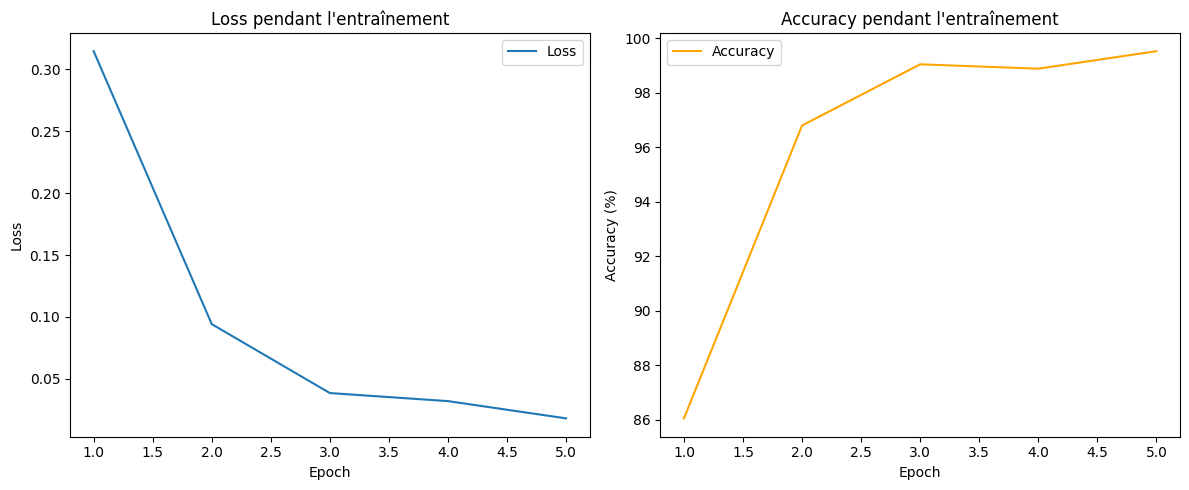

In [6]:
# 📈 Afficher Loss et Accuracy
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss pendant l\'entraînement')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy pendant l\'entraînement')
plt.legend()

plt.tight_layout()
plt.show()

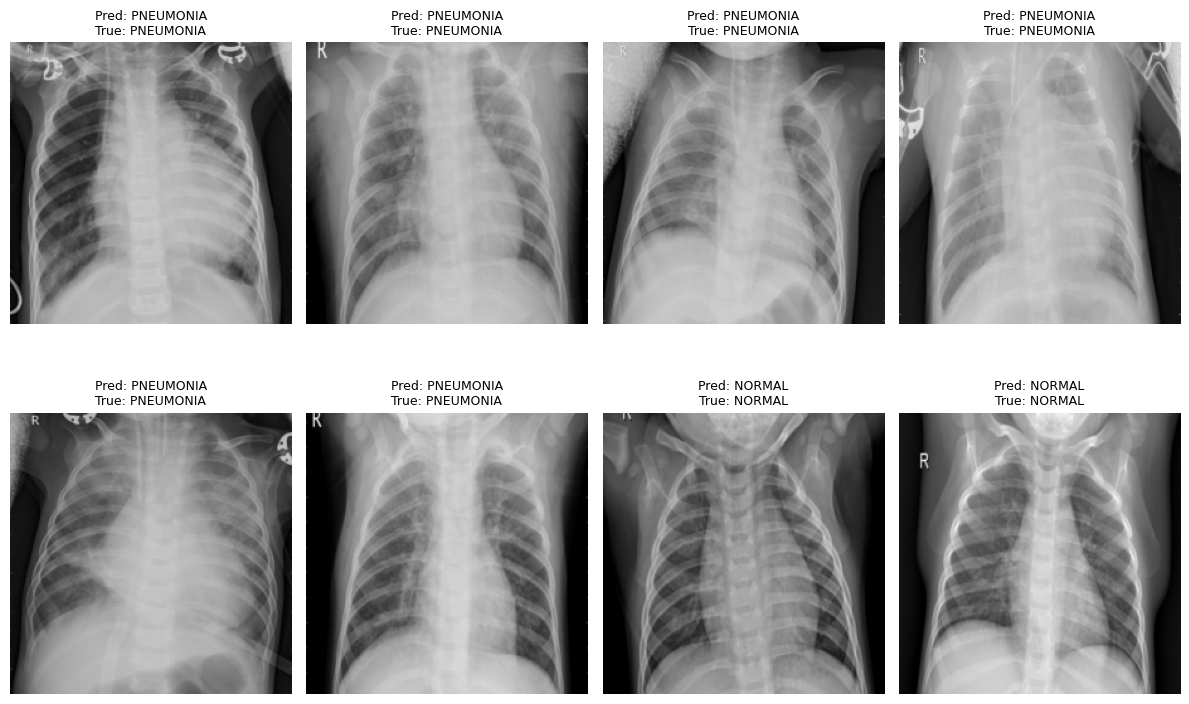

In [7]:
# 🔎 Tester quelques images
model.eval()
inputs, labels = next(iter(dataloader))
inputs, labels = inputs.to(device), labels.to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
# 💾 Sauvegarder le modèle
torch.save(model.state_dict(), "../models/mobilenet_pneumonia.pth")
print("Modèle sauvegardé ✅")

Modèle sauvegardé ✅
